### Simulated reference tracking with a 1R robot
This jupyter notebook simulates tracking control for a 1R robot using adaptive Koopman model predictive control (KMPC), static KMPC, and linearization MPC and compares them. The dynamic parameters of the simulated system correspond to those of the real system which was used for the experiments shown in the paper. The used reference trajectorie corrpesponds to the one used for the real system experiments.   

First, the reference trajectory is loaded and a dynamic model for simulations is built:

In [81]:
# load all dependencies  
include("adaptiveKMPC.jl")   

# load reference trajectory of the single pendulum 
jldopen("./references/simple_pendulum.jld2", "r") do file
    global X_ref = file["xhist"]       
    global U_ref = file["uhist"]
    global T_ref = file["thist"]
end;  

# build single pendulum
m1 = [0.27]                 # link 1 mass 
l1 = [0.4]                  # link 1 lenght 
lc = [0.131]                # distance rotational axis to center of mass (COM) of link 1
I1 = [0.007479]             # moment of inertia of link 1 expressed in COM frame 
sp = nPendulum(m1,l1,lc,I1);
m = 1;                      # number of DOF


building simple pendulum


To clearly show the control processes, each controller is simulated separately. 

First **adaptive KMPC** is simulated. A set of parameters used for the predictive controller is defined and we need to specify a dictionary of lifting functions that are used for obtaining a data-driven linear model via extended dynamic mode decomposition (EDMD):      

In [55]:
# Basis functions (as used in the paper, note we include the original state as the first two entries)
θ1_func(x) = x[1]                           
ω1_func(x) = x[2]
s1_func(x) = sin(x[1])
c1_func(x) = cos(x[1])
ω1s1_func(x) =  x[2]*sin(x[1])
ω1c1_func(x) =  x[2]*cos(x[1])
dict = Dictionary([θ1_func, ω1_func, s1_func, c1_func, ω1s1_func, ω1c1_func]) 

# EDMD parameters 
Nb = 1000                                                     # length of circular buffer, containing data used for EDMD  
edmd_param = EDMDParameters(m, Nb, dict);                     # circular buffer is created within this struct   

# Controller parameters 
Q = [1;zeros(5)]                        # weights on tracking error (with these weight we only put emphasis on tracking of the joint angle θ1)                                    
Qf = [1;zeros(5)]                       # weights on tracking error, final state 
R = ones(m)*1                           # weights on control effort           
H = 30                                  # prediction horizon 
u_l = [-6.0]                            # lower limit on controls 
u_u = [6.0]                             # upper limit on controls 
constr = Constraints(u_l, u_u, H);      
ctrl = AdaptiveKMPC(edmd_param, Q, Qf, R, xhist_ref, H, constr);    # build controller 

The simulated control experiment starts by exposing the system to a sequence of N feed forward controls. For the purpose of this tutorial, we use a sinusoidal torque sequence, such that the system oscillated around its stable equilibrium point. The system response is measured and data are used to fill the circular buffer, providing an initial internal model, such that actual tracking can be carried out. Note that control frequency and discretization of the reference trajectory have to match, such that the internal model produces useful predictions.         

In [ ]:
# Preceding experiment for gathering data 
h = T_ref[2]-T_ref[1]               # discretization step length of the reference trajectory determines control freq. 
X_p = zeros(sp.n, Nb)                                  
U_p = zeros(m, Nb-1)     
T_p = 0:h:h*(Nb-1)

x0 = [0,0]                          # initial state 

X_p[:,1] = x0
for i in 1:Nb-1
    U_p[:,i] .= 0.15*cos(2π*0.05*i*h)           
    X_p[:,i+1] .= simulate(X_p[:,i], U_p[:,i], h, sp)
end      

# fill circular buffer 
update_buffer!(X_p, U_p, T_p, ctrl)

# Reference tracking 
N = 1000                                                                    # duration of the tracking process is given by h*(N-1) (when the reference trajectory ends, the controller will track the last state)
X_c = zeros(sp.n, N)
U_c = zeros(m, N-1)    
T_c = 0:h:h*(N-1) 

X_c[:,1] = X_p[:,end]                                                       # assumption: the tracking process starts immediately after preceding experiment 
for i in 1:N-1         
    U_c[:,i] = get_control(X_c[:,i], i , ctrl)                              # this function carries out the EDMD, building and solving of the MPC problem. Variable names are chosen according to the notation in the paper. 
    X_c[:,i+1] .= simulate(X_c[:,i], U_c[:,i], h, sp)                       # apply control 
    update_buffer!(X_c[:,i+1], U_c[:,i], T_c[i], ctrl)                      # buffer is updated in every time step to provide new data for the EDMD 
end  

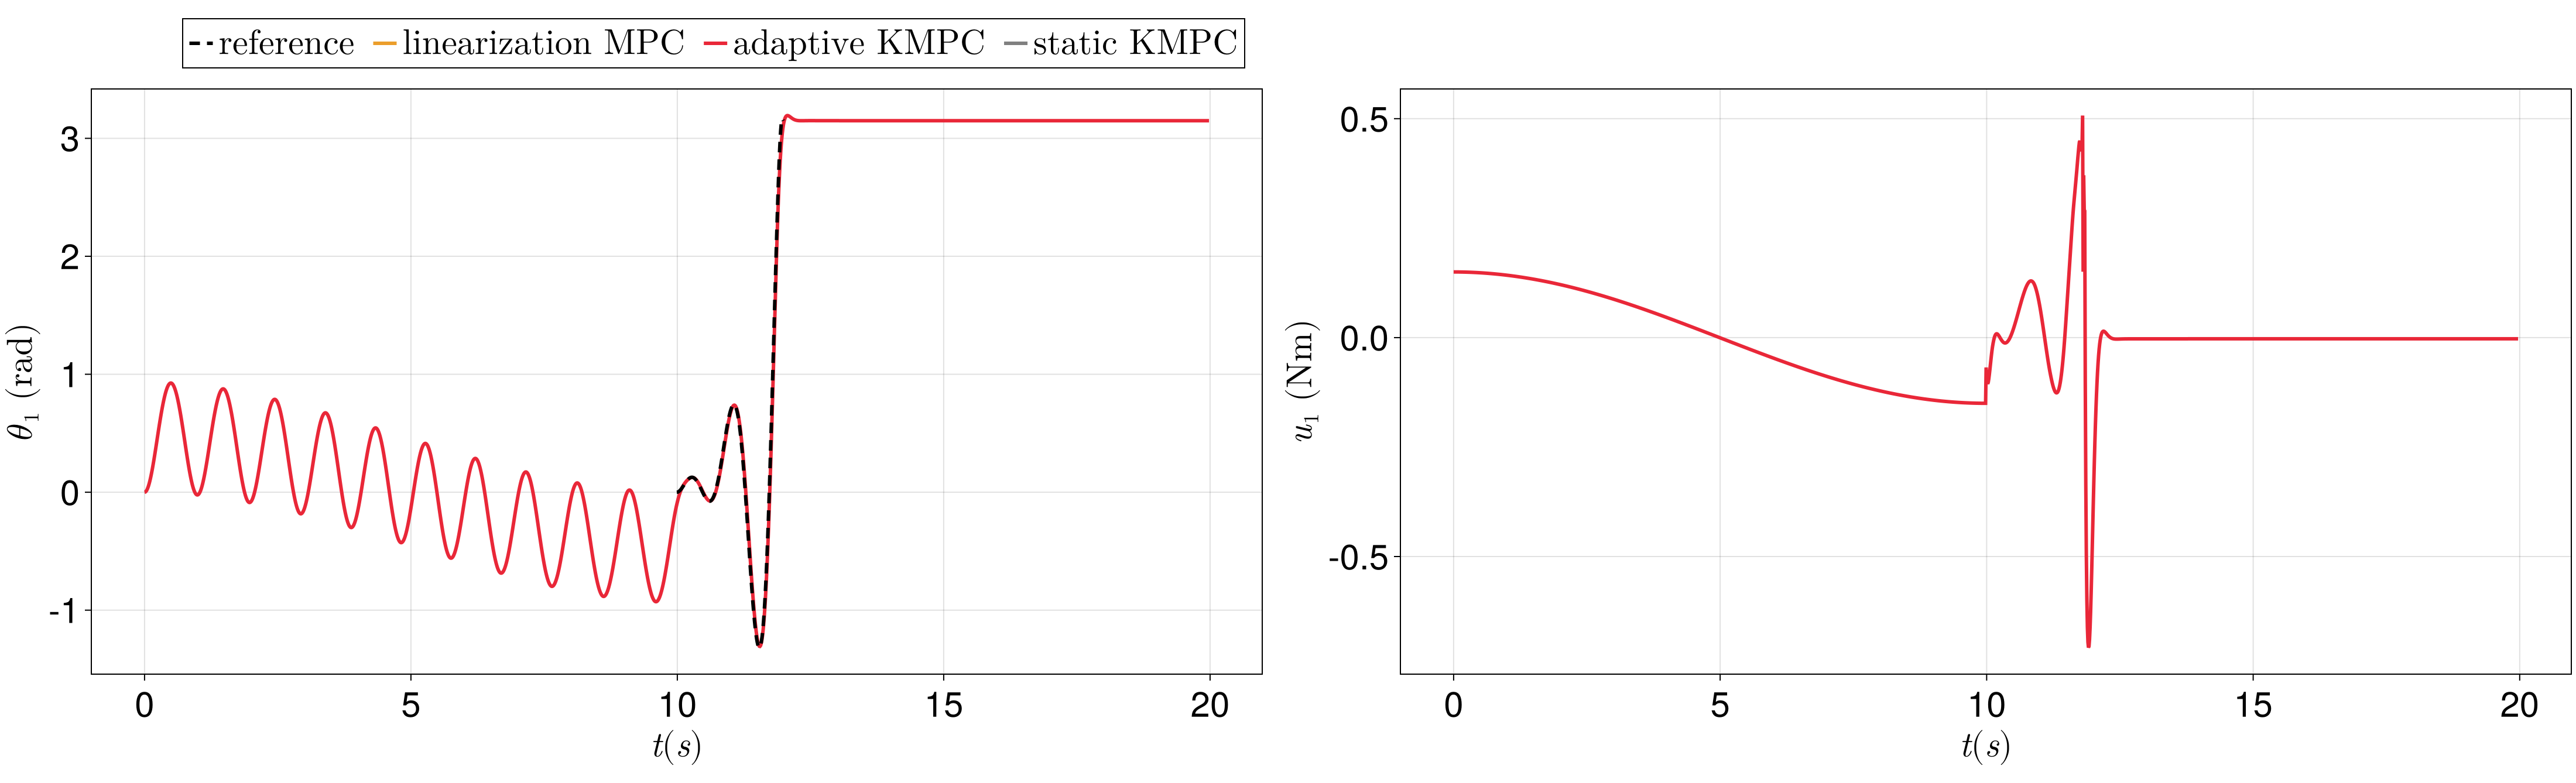

In [93]:
fig = plot_tracking_results(([X_p X_c[:,2:end]],[U_p U_c],[T_p;T_c[2:end].+T_p[end]]), (zeros(n,1),zeros(m,1),zeros(m,1)),  (zeros(n,1),zeros(m,1),zeros(m,1)), (X_ref, T_ref.+T_p[end]))